In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
%matplotlib inline

In [2]:
def print_G(G):
    import pylab
    pos = nx.spring_layout(G)  # positions for all nodes

    nx.draw(G,pos)
    
    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, width=2)
    
# specifiy edge labels explicitly
    edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

    nx.draw_networkx_labels(G, pos, font_size=20
                            , font_family='sans-serif'
                            ,edge_labels=nx.get_edge_attributes(G,'weight').values)

    
    pylab.show()

In [3]:
class RPQ:
    def __init__(self):
        cols_df = ['current_node','distance_from_start','prev_node','time_joined','time']
        self.df = pd.DataFrame(columns=cols_df)
        
        cols_df_visited = ['time','nodes_visited']
        self.df_visited = pd.DataFrame(columns=cols_df_visited)
        
        self.df.loc[len(self.df)] = ['s',0,'s',0,0]
        self.df_visited.loc[len(self.df_visited)] = [0,np.array([])]
        self.visited = []
        self.time = 0
    
    def add_visited(self,node):
        self.visited.append(node)
        
    def update_visited_nodes(self):
        self.df_visited.loc[len(self.df_visited)]=[self.time,str(rpq.visited).translate(None, "[] '").split(',')]

    def increase_time(self):
        self.time = self.time + 1
       
    def insert(self,row):
        self.df.loc[len(self.df)]=row
        self.df = (self.df
                   .sort_values(['time','distance_from_start','time_joined'],ascending=[False,True,True])
                   .reset_index()
                   .drop('index',axis=1)
                  )
    
    def de_dup(self):
        self.df = self.df.drop_duplicates(subset = ['current_node','time'])
    
    def add_timestep(self):
        max_time = self.df.time.max()
        temp = self.df[self.df.time == max_time][1:]
        temp.time = self.time
        self.df = (self.df.append(temp)
                   .sort_values(['time','distance_from_start','time_joined'],ascending=[False,True,True])
                  )
        
        
    def pop_current_node(self):
        ret = self.df.current_node.iloc[0]
        current_tot_weight = self.df.distance_from_start.iloc[0]
        #self.df = self.df.iloc[1:]
        return ret,current_tot_weight
    


In [4]:
# # edges = [('s', 't'),('s', 't'), ('s', 'b'), ('b', 't')]

# # time_off = [np.inf, 3, 1.,  1.]
# # time_on = [3, 1 ,0, 0]
# # weight = [0.1,1,1,1]

# edges = [('s', 'b'), ('b', 't'),('s','e'),('e','t'),('s','t')]
# time_off = [1.,  1., np.inf, np.inf, np.inf]
# time_on = [0, 0, 1, 1,1]
# weight = [1,1,0.01,0.3,0.4]


# time_table = pd.DataFrame(
#             {'edge': edges
#               ,'time_on': time_on
#               ,'time_off': time_off
#               ,'weight': weight
#             }
#             )

# V_A = []
# V_B = []
# for edge in time_table.edge:
#     V_A = np.append(V_A,edge[0])
#     V_B = np.append(V_B,edge[1])
# time_table['V_A'] = V_A
# time_table['V_B'] = V_B
# time_table

In [5]:
G = nx.Graph()


G.add_edge('s', 'a', weight=2)  
G.add_edge('s', 'b', weight=3)
G.add_edge('s', 'c', weight=4)

G.add_edge('a', 'b', weight=2)  
G.add_edge('a', 'd', weight=7)
G.add_edge('a', 'f', weight=12)

G.add_edge('b', 'c', weight=1)  
G.add_edge('b', 'd', weight=4)
G.add_edge('b', 'e', weight=3)

G.add_edge('c', 'e', weight=4)

G.add_edge('d', 'e', weight=4)  
G.add_edge('d', 't', weight=5)

G.add_edge('e', 't', weight=7)

G.add_edge('f', 't', weight=3)


edges = []
weights = []
for k in G.edges:
    edges.append(k)
    weights.append(G.get_edge_data(k[0],k[1]).values()[0]) 
    
time_table = pd.DataFrame(
            {'edge': edges
              ,'weight': weights
            }
            )
time_table['time_on'] = 0
time_table['time_off'] = np.inf

V_A = []
V_B = []
for edge in time_table.edge:
    V_A = np.append(V_A,edge[0])
    V_B = np.append(V_B,edge[1])
time_table['V_A'] = V_A
time_table['V_B'] = V_B
time_table.loc[len(time_table)]=[('s', 't'),1,10,np.inf,'s','t']
#time_table.loc[len(time_table)]=[('a', 'f'),1,5,np.inf,'a','f']

time_table

,edge,weight,time_on,time_off,V_A,V_B
0,"(a, s)",2,0,inf,a,s
1,"(a, b)",2,0,inf,a,b
2,"(a, d)",7,0,inf,a,d
3,"(a, f)",12,0,inf,a,f
4,"(c, s)",4,0,inf,c,s
5,"(c, b)",1,0,inf,c,b
6,"(c, e)",4,0,inf,c,e
7,"(b, s)",3,0,inf,b,s
8,"(b, e)",3,0,inf,b,e
9,"(b, d)",4,0,inf,b,d


In [23]:
G = nx.Graph()

uniq_times = np.unique(time_table[['time_on', 'time_off']].values)[:-1]

rpq = RPQ()

In [25]:
uniq_times

array([  0.,  10.])

0 add  ('a', 's')
0 add  ('a', 'b')
0 add  ('a', 'd')
0 add  ('a', 'f')
0 add  ('c', 's')
0 add  ('c', 'b')
0 add  ('c', 'e')
0 add  ('b', 's')
0 add  ('b', 'e')
0 add  ('b', 'd')
0 add  ('e', 'd')
0 add  ('e', 't')
0 add  ('d', 't')
0 add  ('f', 't')


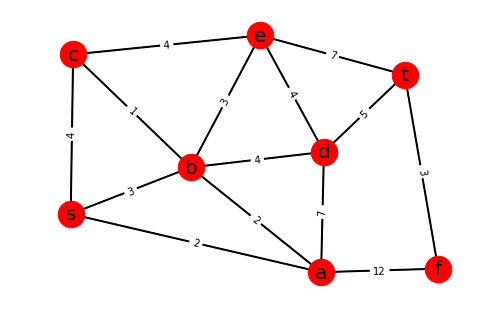

In [26]:
if rpq.time in uniq_times:
    for edge in time_table[time_table.time_off == rpq.time].edge:
        try:
            G.remove_edge(edge[0], edge[1])
            print rpq.time,'rem ', edge
        except:
            pass
    for row in time_table[time_table.time_on == rpq.time].iterrows():
        print rpq.time,'add ', row[1].edge
        G.add_edge(row[1].edge[0], row[1].edge[1],weight = row[1].weight)
        
    print_G(G)

    
current_node, current_tot_weight = rpq.pop_current_node()

list_affected_edges = time_table[(time_table.time_on == rpq.time) | (time_table.time_off == rpq.time)].edge.values
flat_list_edges = list(itertools.chain(*list_affected_edges))

vertex_to_check = list(set(flat_list_edges).intersection(rpq.visited))

In [30]:
rpq.time

1

In [28]:
print vertex_to_check 

if vertex_to_check!=[]:

    for vrtx in vertex_to_check:
        visited = rpq.df.drop_duplicates(subset = ['time'], keep="first").reset_index().drop('index',axis=1)
        inst = visited[visited.current_node == vrtx]
        temp_new_edges = (time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)].
                         reset_index().
                         drop('index'
                              ,axis=1))

        for i in np.arange(0,len(temp_new_edges)):
            if temp_new_edges.V_A.values[0]==vrtx:
                new_vrtx = temp_new_edges.V_B.values[i]
            else:
                new_vrtx = temp_new_edges.V_A.values[i]
            print i,new_vrtx,vrtx
            rpq.insert([new_vrtx
                    ,inst.distance_from_start.values[0]+temp_new_edges.weight[i]
                    ,vrtx
                    ,rpq.time
                    ,rpq.time
                   ])
else:
    pass



[]


In [29]:
#rpq.de_dup()
current_node, current_tot_weight = rpq.pop_current_node()

rpq.add_visited(current_node) ## note that this node has been visited
rpq.increase_time() ## increase timer by 1

# start logging which nodes are considered as visited through time
rpq.update_visited_nodes()
print rpq.df_visited

current_connections = list(G.adj[current_node])
rpq.add_timestep()
visited = rpq.df.drop_duplicates(subset = ['time']).reset_index().drop('index',axis=1)
if vertex_to_check!=[]:
    print "change!!!!!!"
    
    time_in_past = visited[visited.current_node==current_node].time_joined.min()
    rpq.visited=rpq.df_visited[rpq.df_visited.time==time_in_past].nodes_visited.values[0]

nodes_to_check = list(set(current_connections).difference(rpq.visited))

for node in nodes_to_check:
    #print current_node,node,+G[current_node][node].values()[0]
    rpq.insert([node
                ,current_tot_weight+G[current_node][node].values()[0]
                ,current_node
                ,rpq.time
                ,rpq.time
               ])
#rpq.de_dup()
tst=rpq.df.drop_duplicates(subset = ['current_node','time'], keep="first")
#rpq.df=tst
rpq.df

   time nodes_visited
0   0.0            []
1   1.0           [s]


,current_node,distance_from_start,prev_node,time_joined,time
0,a,2.0,s,1.0,1.0
1,b,3.0,s,1.0,1.0
2,c,4.0,s,1.0,1.0
3,s,0.0,s,0.0,0.0


In [ ]:
visited[visited.current_node==current_node]

In [ ]:
current_node

In [ ]:
visited

In [ ]:
visited[visited.current_node==current_node].time_joined.min()

In [ ]:
visited

In [ ]:
vrtx

In [ ]:
# visited = rpq.df.drop_duplicates('time').reset_index().drop('index',axis=1)
# inst = visited[visited.current_node == vrtx]
# temp_new_edges = (time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)].
#                  reset_index().
#                  drop('index'
#                       ,axis=1))

In [ ]:
rpq.time=10

In [ ]:
for vrtx in vertex_to_check:
    print vrtx
    visited = rpq.df.drop_duplicates('time').reset_index().drop('index',axis=1)
    inst = visited[visited.current_node == vrtx]
    temp_new_edges = (time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)].
                     reset_index().
                     drop('index'
                          ,axis=1))

    for i in np.arange(0,len(temp_new_edges)):
        print i,new_vrtx,vrtx
        if temp_new_edges.V_A.values[0]==vrtx:
            new_vrtx = temp_new_edges.V_B.values[i]
        else:
            new_vrtx = temp_new_edges.V_A.values[i]
        print i,new_vrtx,vrtx
#             rpq.insert([new_vrtx
#                     ,inst.distance_from_start.values[0]+temp_new_edges.weight[i]
#                     ,vrtx
#                     ,rpq.time
#                     ,rpq.time
#                    ])

In [ ]:
temp_new_edges

In [ ]:
temp_new_edges

In [ ]:
vrtx='e'

In [ ]:
(time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)].
                     reset_index().
                     drop('index'
                          ,axis=1))

In [ ]:
visited

In [ ]:
rpq.df

In [ ]:
new_vrtx

In [ ]:
temp_new_edges

In [ ]:
inst.distance_from_start.values[0]+temp_new_edges.weight[i]

In [ ]:
for i in np.arange(0,len(temp_new_edges)):
                 print i

In [ ]:
temp_new_edges.V_B.values[0]

In [ ]:
new_vrtx

In [ ]:
temp_new_edges.V_A.values[0]

In [ ]:
# G = nx.Graph()


# G.add_edge('o', 'a', weight=2)  
# G.add_edge('o', 'b', weight=5)
# G.add_edge('o', 'c', weight=4)

# G.add_edge('a', 'b', weight=2)  
# G.add_edge('a', 'd', weight=7)
# G.add_edge('a', 'f', weight=12)

# G.add_edge('b', 'c', weight=1)  
# G.add_edge('b', 'd', weight=4)
# G.add_edge('b', 'e', weight=3)

# G.add_edge('c', 'e', weight=4)

# G.add_edge('d', 'e', weight=4)  
# G.add_edge('d', 't', weight=5)

# G.add_edge('e', 't', weight=7)

# G.add_edge('f', 't', weight=3)



In [ ]:
time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)]

In [ ]:
temp_new_edges = (time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)].
                         reset_index().
                         drop('index'
                              ,axis=1))

In [ ]:
a = time_table.edge.values
b = 't'
[list(set(sublist).intersection(set(b))) for sublist in a]

In [ ]:
list_affected_edges

In [ ]:
time_table.edge.values

In [ ]:
current_node

In [ ]:
rpq.time

In [ ]:
# G = nx.Graph()

# uniq_times = np.unique(time_table[['time_on', 'time_off']].values)[:-1]
# for i in uniq_times:
#     for edge in time_table[time_table.time_off == i].edge:
#         try:
#             G.remove_edge(edge[0], edge[1])
#             print i,'rem ', edge
#         except:
#             pass
#     for row in time_table[time_table.time_on == i].iterrows():
#         print i,'add ', row[1][0]
#         G.add_edge(row[1][0][0], row[1][0][1],weight = row[1][3])
        
#     print_G(G)

In [ ]:
G = nx.Graph()


G.add_edge('s', 'a', weight=2)  
G.add_edge('s', 'b', weight=5)
G.add_edge('s', 'c', weight=4)

G.add_edge('a', 'b', weight=2)  
G.add_edge('a', 'd', weight=7)
G.add_edge('a', 'f', weight=12)

G.add_edge('b', 'c', weight=1)  
G.add_edge('b', 'd', weight=4)
G.add_edge('b', 'e', weight=3)

G.add_edge('c', 'e', weight=4)

G.add_edge('d', 'e', weight=4)  
G.add_edge('d', 't', weight=5)

G.add_edge('e', 't', weight=7)

G.add_edge('f', 't', weight=3)

In [ ]:
rpq = RPQ()

In [ ]:
current_node, current_tot_weight = rpq.pop_current_node()
print current_node,current_tot_weight
rpq.add_visited(current_node) ## note that this node has been visited
rpq.increase_time() ## increase timer by 1

current_connections = list(G.adj[current_node])
rpq.add_timestep()

for node in list(set(current_connections).difference(rpq.visited)):
    print current_node,node,+G[current_node][node].values()[0]
    rpq.insert([node
                ,current_tot_weight+G[current_node][node].values()[0]
                ,current_node
                ,rpq.time
                ,rpq.time
               ])
rpq.de_dup()


In [ ]:
rpq.pop_current_node()

In [ ]:
rpq.visited

In [ ]:
time_table